## Generic Comparison Code

In [1]:
def xr_stats_2d(arr1, arr2, area, fmt="list"):
    # load arrays into memory to prevent any warnings later
    arr1.load()
    arr2.load()
    # the two arrays may have different valid data masks
    # get the union of masks from both arrays
    mask = xr.where(arr1.isnull(), 0.0, 1.0) * xr.where(arr2.isnull(), 0.0, 1.0)
    # fill all NaNs with zeros and apply the unified mask to all arrays
    _arr1 = arr1.fillna(0.0) * mask
    _arr2 = arr2.fillna(0.0) * mask
    _area = area * mask
    # calculate difference of arrays
    diff = _arr1 - _arr2
    # calculate area-weighted bias
    bias = diff.weighted(_area).mean()
    # rmse
    rse = xr.ufuncs.sqrt(diff**2)
    rmse = rse.weighted(_area).mean()    
    # Xarray, Pandas, and Numpy do not have a multidimensional function
    # to compute a weighted pattern correlation. Define internal functions
    # for weighted covariance and correlation
    def _cov(arr1, arr2, area):
        """Weighted Covariance"""
        return np.sum(
            area
            * (arr1 - np.average(arr1, weights=area))
            * (arr2 - np.average(arr2, weights=area))
        ) / np.sum(area)
    def _corr(arr1, arr2, area):
        """Weighted Correlation"""
        return _cov(arr1, arr2, area) / np.sqrt(_cov(arr1, arr1, area) * _cov(arr2, arr2, area))
    # convert to numpy arrays
    _arr1 = _arr1.values
    _arr2 = _arr2.values
    _area = _area.values
    # weighted pattern correlation
    rsquared = _corr(_arr1, _arr2, _area)
    result = [float(bias.values),float(rmse.values),float(rsquared)]
    if fmt == "dict":
        result = dict(zip(["bias","rmse","rsquared"],result))
    return result

In [2]:
%matplotlib inline

import xarray as xr
import xgcm
from xgcm import Grid
import numpy as np
import xesmf as xe

In [22]:
ds1 = xr.open_mfdataset(["ocean_annual_z.1995-1999.ann.nc","CM4.static.nc"])
ds2 = xr.open_mfdataset(["ocean_annual_z.2000-2004.ann.nc","ESM4.static.nc"])

In [31]:
ds1 = xr.open_mfdataset(["ESM2G.atmos.nc","ESM2G.atmos.static.nc"])
ds2 = xr.open_mfdataset(["ESM4.atmos.nc","ESM4.atmos.static.nc"])

In [ ]:
ds2

In [ ]:
thetao_cm4 = ds1.thetao
thetao_esm4 = ds2.thetao

In [ ]:
def rename_dims(arr):
    tdim = infer_dim_name(arr,TIME_DIMS)
    ydim = infer_dim_name(arr,LAT_DIMS)
    xdim = infer_dim_name(arr,LON_DIMS)
    zdim = infer_dim_name(arr,Z_DIMS)
    
    if tdim is not None:
        arr = arr.rename({tdim:"time"})
        
    if zdim is not None:
        arr = arr.rename({zdim:"z"})
        
    if ydim is not None:
        arr = arr.rename({ydim:"y"})
        
    if xdim is not None:
        arr = arr.rename({xdim:"x"})
        
    return arr

In [ ]:
ds1.dims

In [ ]:
def equal_spatial_dims(arr1, arr2, verbose=True, rtol=1e-05, atol=1e-08):

    arr1_dims = [x for x in arr1.dims if x.lower() not in TIME_DIMS]
    arr2_dims = [x for x in arr2.dims if x.lower() not in TIME_DIMS]

    if arr1_dims == arr2_dims:
        checked = [
            np.ma.allclose(arr1[x].values, arr2[x].values, rtol=rtol, atol=atol)
            for x in arr1_dims
        ]
        if all(checked):
            print(
                f"Arrays `{arr1.name}` and `{arr2.name}` have the same dimension names and values"
            )

        return all(checked)

In [ ]:
def infer_geolat_geolon(ds_static, dims):

    if dims == ("yh", "xh"):
        geolon = ds_static["geolon"]
        geolat = ds_static["geolat"]

    return geolat, geolon

In [ ]:
def regrid(arr1,arr2,static1,static2):
    ydim1 = infer_dim_name(arr1,LAT_DIMS)
    xdim1 = infer_dim_name(arr1,LON_DIMS)
    dims1 = (ydim1,xdim1)
    
    ydim2 = infer_dim_name(arr2,LAT_DIMS)
    xdim2 = infer_dim_name(arr2,LON_DIMS)
    dims2 = (ydim2,xdim2)
    
    geolat1, geolon1 = infer_geolat_geolon(static1,dims1)
    ds1 = xr.Dataset()
    ds1["lon"] = geolon1
    ds1["lat"] = geolat1
    ds1[arr1.name] = arr1
    
    geolat2, geolon2 = infer_geolat_geolon(static2,dims2)
    ds2 = xr.Dataset()
    ds2["lon"] = geolon2
    ds2["lat"] = geolat2
    ds2[arr2.name] = arr2 

    regridder = xe.Regridder(ds2, ds1, 'bilinear')
    
    arr2 = regridder(arr2)
    
    return (arr1,arr2)

In [ ]:
OCEAN_CENTERS = [("yh","xh")]

In [ ]:
def associate_lon_lat(arr, static):
    ydim = infer_dim_name(arr, LAT_DIMS)
    xdim = infer_dim_name(arr, LON_DIMS)
    dims = (ydim, xdim)

    if dims in OCEAN_CENTERS:
        lon = static["geolon"]
        lat = static["geolat"]

    dset_out = xr.Dataset()
    dset_out["lon"] = lon
    dset_out["lat"] = lat
    dset_out[arr.name] = arr

    return dset_out

In [4]:
# recognized rectilinear dimension names for cell centers
RECT_LAT_DIMS = ["lat","latitude"]
RECT_LON_DIMS = ["lon","longitude"]

# recognized curvilinear cell center dim names
CURV_LAT_CENTERS = ["yh"]
CURV_LON_CENTERS = ["xh"]

# recognized curvilinear cell corner dim names
CURV_LAT_CORNERS = ["yq"]
CURV_LON_CORNERS = ["xq"]

# recognized vertical dimension names
Z_ATM_DIMS = ["level","z"]
Z_OCN_DIMS = ["z_l","z_i","depth"]

# ocean grids
OCEAN_GRIDS = [("yh","xh")]

# time dimensions
TIME_DIMS = ["time","t","tax","month","year","day","date"]

LAT_DIMS = RECT_LAT_DIMS + CURV_LAT_CENTERS + CURV_LAT_CORNERS
LON_DIMS = RECT_LON_DIMS + CURV_LON_CENTERS + CURV_LON_CORNERS
Z_DIMS = Z_ATM_DIMS + Z_OCN_DIMS

In [5]:
def infer_dim_name(arr,dimlist):
    arrdim = [x for x in arr.dims if x in dimlist]
    assert len(arrdim) <= 1, f"Multiple dimensions found: {arrdim}"
    return arrdim[0] if len(arrdim)==1 else None

In [6]:
def reorder_dims(arr):
    tdim = infer_dim_name(arr,TIME_DIMS)
    ydim = infer_dim_name(arr,LAT_DIMS)
    xdim = infer_dim_name(arr,LON_DIMS)
    zdim = infer_dim_name(arr,Z_DIMS)
    
    dims = [tdim,zdim,ydim,xdim]
    dims = [x for x in dims if x is not None]
    dims = tuple(dims)
    
    return arr.transpose(...,*dims)

In [7]:
def extract_var_from_dataset(ds,varlist=None):
    result = xr.Dataset()
    varlist = ds.variables if varlist is None else varlist
    for var in varlist:
        
        # setup a local array
        _arr = ds[var]
        
        # remove singleton dimensions and reorder
        _arr = _arr.squeeze().reset_coords(drop=True)
        _arr = reorder_dims(_arr)
        
        # extract cell area
        if "area" in ds.variables:
            result["area"] = ds["area"]
        
        # create a tuple of existing coordinates
        coords = _arr.coords
        coords = [(x,ds[x]) for x in coords]
        
        # infer the x and y dimension name
        xdim = infer_dim_name(_arr,LON_DIMS)
        ydim = infer_dim_name(_arr,LAT_DIMS)
        horiz_coord = (xdim,ydim)
        
        if horiz_coord == ("xh","yh"):
            result["area"] = ds["areacello"]
            coords = [("lon",ds["geolon"]) if x[0] == "xh" else (x[0],x[1]) for x in coords]
            coords = [("lat",ds["geolat"]) if x[0] == "yh" else (x[0],x[1]) for x in coords]

        
        # reassign coordinates
        coords = dict(coords)
        _arr = _arr.assign_coords(coords)
        
        # append to new dataset
        result[var] = _arr
        
    return result

In [8]:
def equal_horiz_dims(ds1, ds2):

    assert ("lon" in ds1.variables) and (
        "lat" in ds1.variables
    ), "Dataset 1 must contain lat & lon"
    assert ("lon" in ds2.variables) and (
        "lat" in ds2.variables
    ), "Dataset 2 must contain lat & lon"

    return (ds1.lon.shape == ds2.lon.shape) and (ds1.lat.shape == ds2.lat.shape)

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter")

In [32]:
def compare_datasets(ds1, ds2, verbose=True, varlist=None):

    ds1 = extract_var_from_dataset(ds1,varlist=varlist)
    ds2 = extract_var_from_dataset(ds2,varlist=varlist)
    
    if equal_horiz_dims(ds1,ds2):
        diff = ds1 - ds2

    else:
        
        ds1.load()
        ds2.load()
                        
        if np.multiply(*ds1[varlist[0]].shape[-2::]) > np.multiply(*ds2[varlist[0]].shape[-2::]):
            regridder = xe.Regridder(ds1, ds2, "bilinear")
            attrs = {x:ds1[x].attrs for x in varlist}
            ds1 = regridder(ds1)
            for x in varlist:
                ds1[x] = ds1[x].assign_attrs(attrs[x])
            area = ds2["area"]
        else:
            regridder = xe.Regridder(ds2, ds1, "bilinear")
            attrs = {x:ds2[x].attrs for x in varlist}
            ds2 = regridder(ds2)
            for x in varlist:
                ds2[x] = ds2[x].assign_attrs(attrs[x])
            area = ds1["area"]
        
        # create difference array
        diff = ds1 - ds2
        
        # include cell area
        diff["area"] = area
        
        # compute statistics
        for x in varlist:
            diff[x] = diff[x].assign_attrs(xr_stats_2d(ds1[x],ds2[x],area,fmt="dict"))
    
    return (ds1,ds2,diff)
    

#results = compare_datasets(ds1.isel(z_l=0),ds2.isel(z_l=0),varlist=["so","thetao"])
results = compare_datasets(ds1,ds2,varlist=["t_ref","precip"])

/Users/krasting/miniconda3/envs/py39/lib/python3.9/site-packages/xesmf/frontend.py:487: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [33]:
results[2]

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
Data variables:
    area     (lat, lon) float32 2.758e+08 2.758e+08 ... 2.758e+08 2.758e+08
    t_ref    (lat, lon) float64 6.626 6.687 6.747 6.812 ... -1.58 -1.585 -1.59
    precip   (lat, lon) float64 6.758e-07 6.759e-07 ... -2.047e-06 -2.047e-06

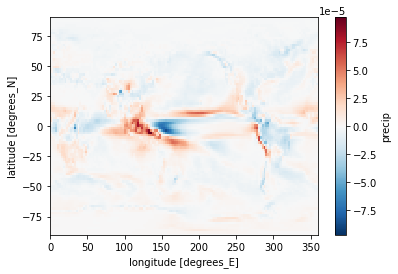

In [34]:
results[2].precip.plot()

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

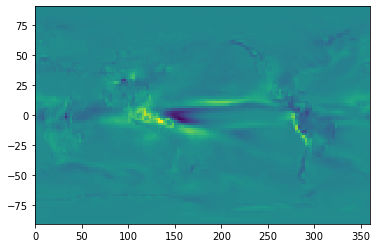

In [35]:
D = results[2]
plt.pcolormesh(D.lon,D.lat,D.precip,shading="auto")